In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import pickle

In [26]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
batch_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
# MNIST dataset
train_dataset = datasets.MNIST(root='../datasets/',
                               train=True,
                               transform=transform,
                               download=True)

test_dataset = datasets.MNIST(root='../datasets/',
                                train=False,
                                transform=transform)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False)


In [28]:
# defining the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        
        return x

In [29]:
'''
https://pytorch.org/docs/stable/generated/torch.addcdiv.html#torch.addcdiv

For addcdiv_ used at last

'''
class customAdam(torch.optim.Optimizer):


    def __init__(self,params,lr = 1e-3,betas = (0.99,0.999),eps = 1e-3):
        defaults = dict(lr = lr, betas = betas, eps = eps)
        super(customAdam,self).__init__(params,defaults)

    def __setstate__(self, state) -> None:
        return super(customAdam).__setstate__(state)
  
    def step(self,closure = None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            # print(self.param_groups)
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                # print(grad)
                state = self.state[p]
                # print(state)
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    beta1, beta2 = group['betas']
                    state['step'] += 1

                    state['exp_avg'] = beta1 * state['exp_avg'] + (1 - beta1) * grad
                    state['exp_avg_sq'] = beta2 * state['exp_avg_sq'] + (1 - beta2) * grad**2

                    bias_correction1 = 1 - beta1**state['step']
                    bias_correction2 = 1 - beta2**state['step']

                    p.data.addcdiv_(-group['lr'] / bias_correction1,state['exp_avg'],(state['exp_avg_sq'] / bias_correction2).sqrt() + group['eps'])

                else:
                    beta1, beta2 = group['betas']
                    state['step'] += 1
                    state['exp_avg'] = beta1 * state['exp_avg'] + (1 - beta1) * grad
                    state['exp_avg_sq'] = beta2 * state['exp_avg_sq'] + (1 - beta2) * grad**2

                    bias_correction1 = 1 - beta1**state['step']
                    bias_correction2 = 1 - beta2**state['step']

                    p.data.addcdiv_(-group['lr'] / bias_correction1,state['exp_avg'],(state['exp_avg_sq'] / bias_correction2).sqrt() + group['eps'])

        return loss


In [30]:
# training the model
criterion = nn.CrossEntropyLoss()
epochs = 100

In [31]:
# A class containing the functions for
class Trainer():
    def __init__(self, model, optimizer, lr=0.001, epochs=5):
        self.model = model

        self.lr = lr
        self.optimizer = optimizer(self.model.parameters(), lr=lr)

        self.epochs = epochs

        # defining local variables for the class
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []


    def train(self):
        # train loop

        for epoch in range(self.epochs):
            running_loss = 0
            
            self.model.train()

            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = criterion(output, target)
                loss.backward()
                self.optimizer.step()
                
                running_loss += loss.item()
                accuracy = 100*torch.sum(torch.argmax(output, dim=1) == target).item()/len(target)

                # break

            self.train_loss.append(running_loss/len(train_loader))
            self.train_acc.append(accuracy)


            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = self.model(data)
                    val_loss += criterion(output, target).item()

                    val_acc = 100*torch.sum(torch.argmax(output, dim=1) == target).item()/len(target)

            self.val_loss.append(val_loss/len(test_loader))
            self.val_acc.append(val_acc)

            if (epoch%10==9):
                print(f"Epoch: {epoch+1}/{epochs} ::     Train Loss: {running_loss/len(train_loader)}...     Val Loss: {val_loss/len(test_loader)}")                    

        return
        

    def plot_graph(self):
        epoch_x = [i for i in range(1, self.epochs+1)]
        
        # plot loss and accuracy curves for train and validation in two separate graphs
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        axs[0].plot(epoch_x, self.train_loss, label='Train Loss')
        axs[0].plot(epoch_x, self.val_loss, label='Val Loss')
        axs[0].set_title('Loss')
        axs[0].legend()

        axs[1].plot(epoch_x, self.train_acc, label='Train Accuracy')
        axs[1].plot(epoch_x, self.val_acc, label='Val Accuracy')
        axs[1].set_title('Accuracy')
        axs[1].legend()

        return         

In [32]:
model1 = Net().to(device)
trainer1 = Trainer(model1, optim.Adam, epochs=epochs)

In [34]:
trainer1.train()

Epoch: 10/100 ::     Train Loss: 8.405195238360725e-05...     Val Loss: 0.09891540575772524
Epoch: 20/100 ::     Train Loss: 4.702027128309888e-05...     Val Loss: 0.10436728242784739
Epoch: 30/100 ::     Train Loss: 2.797947943968288e-05...     Val Loss: 0.11044197557494044
Epoch: 40/100 ::     Train Loss: 1.674404397894928e-05...     Val Loss: 0.116494264267385
Epoch: 50/100 ::     Train Loss: 1.0537797098257185e-05...     Val Loss: 0.12135785119608045


KeyboardInterrupt: 

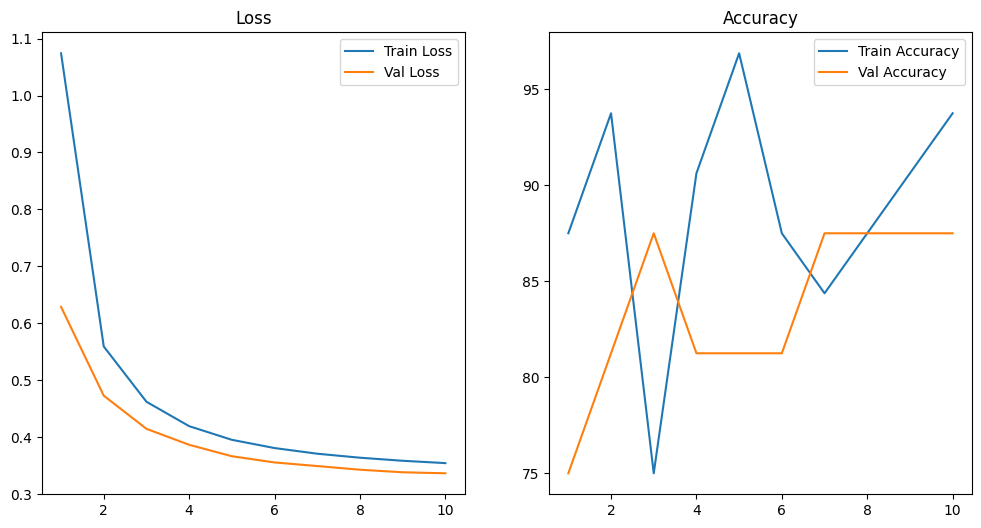

In [ ]:
trainer1.plot_graph()

In [ ]:
'''
https://pytorch.org/docs/stable/generated/torch.addcdiv.html#torch.addcdiv

For addcdiv_ used at last

'''
class customAdam2(torch.optim.Optimizer):


    def __init__(self,params,lr = 1e-3,betas = (0.99,0.999),eps = 1e-3):
        defaults = dict(lr = lr, betas = betas, eps = eps)
        super(customAdam2,self).__init__(params,defaults)

    def __setstate__(self, state) -> None:
        return super(customAdam2).__setstate__(state)
  
    def step(self,closure = None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            # print(self.param_groups)
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                # print(grad)
                state = self.state[p]
                # print(state)
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    beta1, beta2 = group['betas']
                    state['step'] += 1

                    state['exp_avg'] = beta1 * state['exp_avg'] + (1 - beta1) * grad
                    state['exp_avg_sq'] = beta2 * state['exp_avg_sq'] + (1 - beta2) * grad**2

                    bias_correction1 = 1 - beta1
                    bias_correction2 = 1 - beta2

                    p.data.addcdiv_(-group['lr'] / bias_correction1,state['exp_avg'],(state['exp_avg_sq'] / bias_correction2).sqrt() + group['eps'])

                else:
                    beta1, beta2 = group['betas']
                    state['step'] += 1
                    state['exp_avg'] = beta1 * state['exp_avg'] + (1 - beta1) * grad
                    state['exp_avg_sq'] = beta2 * state['exp_avg_sq'] + (1 - beta2) * grad**2

                    bias_correction1 = 1 - beta1
                    bias_correction2 = 1 - beta2

                    p.data.addcdiv_(-group['lr'] / bias_correction1,state['exp_avg'],(state['exp_avg_sq'] / bias_correction2).sqrt() + group['eps'])

        return loss


In [36]:
model2 = Net().to(device)
trainer2 = Trainer(model2, customAdam, epochs=epochs)

In [37]:
trainer2.train()

Epoch: 10/100 ::     Train Loss: 0.673647804785583...     Val Loss: 0.6336244732141495
Epoch: 20/100 ::     Train Loss: 0.5022834322210086...     Val Loss: 0.4757830798625946
Epoch: 30/100 ::     Train Loss: 0.43812915278693376...     Val Loss: 0.41539549082517624
Epoch: 40/100 ::     Train Loss: 0.40401699684434017...     Val Loss: 0.3832788333296776
Epoch: 50/100 ::     Train Loss: 0.3833172629445286...     Val Loss: 0.36374448984861374
Epoch: 60/100 ::     Train Loss: 0.3695167338444015...     Val Loss: 0.35110925436019896
Epoch: 70/100 ::     Train Loss: 0.35963150151705336...     Val Loss: 0.3426060527563095
Epoch: 80/100 ::     Train Loss: 0.3526776190531456...     Val Loss: 0.3362961530685425
Epoch: 90/100 ::     Train Loss: 0.34767772737195934...     Val Loss: 0.33183359950780866
Epoch: 100/100 ::     Train Loss: 0.34369260375782595...     Val Loss: 0.32831860780715943


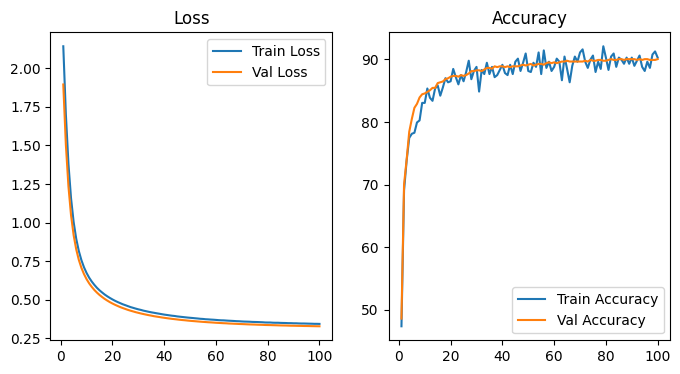

In [38]:
trainer2.plot_graph()